#  Homework 5 - Berkeley STAT 157


In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import random
import mxnet as mx

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True,transform=lambda data, label: (data.astype(np.float32), label))
mnist_test = gdata.vision.FashionMNIST(train=False,transform=lambda data, label: (data.astype(np.float32), label))

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

In [3]:
# problem 1
def loss(y,o):
    ## add your loss function here
    l = - nd.log(1 + nd.exp(- nd.dot(y, o)))
    return l

In [208]:
#Problem 2
import matplotlib.pyplot as plt
o = nd.arange(-5, 5, 0.01).reshape((1,1000))
y = nd.array([1])
l = loss(y, o)

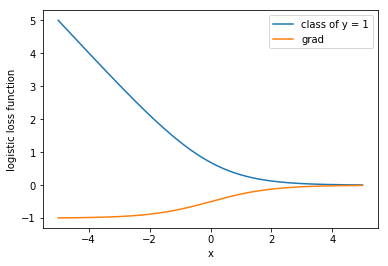

In [209]:
onp = o.asnumpy()[0]
plt.plot(onp,-l.asnumpy(), label = 'class of y = 1')
plt.xlabel('x')
plt.ylabel('logistic loss function')

o.attach_grad()
with autograd.record():
    func = -loss(y,o)
func.backward()
plt.plot(onp,o.grad.asnumpy().reshape(1000,),label = 'grad')
plt.xlabel('x')
plt.legend(loc = 'best')

plt.legend(loc = 'best')
plt.show()

### Train dataset and Test dataset

In [4]:
def generate_data(mnist_train, mnist_test,bias, total):
    '''
    biased ratio is for problem 3
    total would be the total sample for each class.
    '''
    
    X, y = mnist_train[:]
    pullover =  np.where(y == 2)[0].tolist()
    sneaker = np.where(y == 7)[0].tolist()
    
    shirt = np.where(y == 6)[0].tolist()
    sandal = np.where(y == 5)[0].tolist()
    
    
    class1_portion = round(bias * total)
    class2_portion = round((1 - bias) * total)
    
    #for train dataset
    #index_coat = random.sample(coat, class1_portion)
    #index_shirt = random.sample(shirt, class1_portion)
    #index_sandal = random.sample(sandal, class2_portion)
    #index_sneaker = random.sample(sneaker, class2_portion)
    
    index_pullover = pullover[0:class1_portion] # 600
    index_sneaker = sneaker[0:class1_portion] # 600
    
    index_shirt = shirt[0:class2_portion] # 5400
    index_sandal = sandal[0:class2_portion] #5400

    
    train_pullover = X[index_pullover]
    train_sneaker = X[index_sneaker]
    
    train_shirt = X[index_shirt]
    train_sandal = X[index_sandal]
    
     
    train_feature = nd.concat(train_pullover, train_sneaker, train_shirt, train_sandal, dim=0)
    #train_feature = nd.concat(train_pullover, train_shirt, train_sneaker, train_sandal, dim=0)
    
    label1 = nd.ones((1, total)).astype(np.float32)
    label2 = nd.zeros((1, total)).astype(np.float32)
    
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    
    #for test dataset    
    A, b = mnist_test[:]
    indices_1 = np.where(np.logical_or(b == 2, b == 7))[0].tolist() #clothes flipped
    indices_2 = np.where(np.logical_or(b == 6, b == 5))[0].tolist() #shoes
    
    #indices_1 = np.where(np.logical_or(b == 2, b == 6))[0].tolist() #clothes
    #indices_2 = np.where(np.logical_or(b == 7, b == 5))[0].tolist() #shoes
    class1 = A[indices_1] #class1
    class0 = A[indices_2] #class-1
    test_feature = nd.concat(class1, class0,dim = 0)
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label0 = nd.zeros((1,2000)).astype(np.float32)
    test_label = nd.concat(label1,label0,dim = 1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_label)    
    return train_data, test_data

### Train all samples

In [4]:
import d2l,random
train_all, test_all = generate_data(mnist_train, mnist_test,0.5, 12000)

In [5]:
def model(train, test, batch_size, lr, num_epochs):
    train_iter = gdata.DataLoader(train, batch_size,shuffle = True)
    test_iter = gdata.DataLoader(test, batch_size,shuffle = True)

    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.initialize(init.Normal(sigma=0.01))

    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

In [6]:
model(train_all, test_all, 256, 0.02, 10)

epoch 1, loss 10825.1328, train acc 0.645, test acc 0.762
epoch 2, loss 5235.8789, train acc 0.758, test acc 0.858
epoch 3, loss 4827.5645, train acc 0.778, test acc 0.869
epoch 4, loss 4314.0024, train acc 0.793, test acc 0.848
epoch 5, loss 4242.1430, train acc 0.793, test acc 0.869
epoch 6, loss 3631.4309, train acc 0.815, test acc 0.873
epoch 7, loss 4381.1091, train acc 0.792, test acc 0.875
epoch 8, loss 3458.9050, train acc 0.818, test acc 0.845
epoch 9, loss 3706.5656, train acc 0.807, test acc 0.881
epoch 10, loss 3695.6305, train acc 0.812, test acc 0.874


### Train half sample

In [7]:
train_half, test_half = generate_data(mnist_train, mnist_test,0.5, 6000)

In [8]:
model(train_half, test_half, 256, 0.01, 10)

epoch 1, loss 6761.6128, train acc 0.585, test acc 0.659
epoch 2, loss 3832.0859, train acc 0.689, test acc 0.612
epoch 3, loss 2934.9573, train acc 0.740, test acc 0.815
epoch 4, loss 2744.7616, train acc 0.759, test acc 0.813
epoch 5, loss 2139.4865, train acc 0.795, test acc 0.852
epoch 6, loss 2668.8411, train acc 0.762, test acc 0.870
epoch 7, loss 2620.7927, train acc 0.768, test acc 0.846
epoch 8, loss 2140.0285, train acc 0.804, test acc 0.806
epoch 9, loss 2364.9301, train acc 0.778, test acc 0.871
epoch 10, loss 2151.9523, train acc 0.797, test acc 0.874


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $600$ `sweater` images and likewise $5,400$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [9]:
lam = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

In [19]:
for i in lam:
    train_shift, test_shift = generate_data(mnist_train, mnist_test,i, 6000)
    print('Bias is %.2f' %i)
    model(train_shift, test_shift, 128, 0.01, 5)

Bias is 0.05
epoch 1, loss 941.2027, train acc 0.874, test acc 0.570
epoch 2, loss 722.3783, train acc 0.901, test acc 0.590
epoch 3, loss 673.3000, train acc 0.903, test acc 0.504
epoch 4, loss 719.7617, train acc 0.911, test acc 0.616
epoch 5, loss 502.3603, train acc 0.908, test acc 0.660
Bias is 0.10
epoch 1, loss 2063.1038, train acc 0.791, test acc 0.583
epoch 2, loss 1429.2275, train acc 0.840, test acc 0.693
epoch 3, loss 1391.8873, train acc 0.842, test acc 0.627
epoch 4, loss 1431.7786, train acc 0.844, test acc 0.588
epoch 5, loss 1480.7845, train acc 0.845, test acc 0.644
Bias is 0.20
epoch 1, loss 3916.1632, train acc 0.686, test acc 0.588
epoch 2, loss 3120.7885, train acc 0.734, test acc 0.702
epoch 3, loss 2814.6490, train acc 0.751, test acc 0.699
epoch 4, loss 2980.3434, train acc 0.751, test acc 0.723
epoch 5, loss 2866.8748, train acc 0.763, test acc 0.697
Bias is 0.30
epoch 1, loss 5222.9813, train acc 0.628, test acc 0.641
epoch 2, loss 4453.8252, train acc 0.688,

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


#### Answer
1. To minimize the loss function when the data come from unbiased dataset, which has the distribution p(x) (here is the testing set): 
$$\min_w\int{dxp(x)}\int{dyp(y|x)l(f(x,w),y)}$$
where p(x) is the 'correct' distribution and q(x) is the 'wrong' one.   
While the empirical form could be descirbed as:
$$\min_x\frac{1}{n}\sum_{i}(l(x_i,y_i),f(x_i))$$
But when the data come from biased dataset(here is the training set, which has the distribution q(x), the formula becomes:
$$\min_w\int{dxq(x)}\int{dyp(y|x)l(f(x,w),y)}$$
So re-weighting data to adjust the q(x) back to p(x) would help the function become unbiased. Therefore, the weight when training the binary classification should be:
$$\beta(x) = \frac{p(x)}{q(x)} $$
The joint probability distribution is (label data from train as -1, from test as 1:
$$r(x,y) = \frac{N_{test}}{N}p(x)\delta(y,1) + \frac{N_{train}}{N}q(x)\delta(y,-1)$$
$$r(y = 1|x) = \frac{r(x,y=1)}{r(x)} = \frac{r(x,y=1)}{r(x|y=1) + r(x|y=-1)} = $$   
$$\frac{r(x,y=1)}{r(x, y=1) + r(x, y=-1)} = \frac{N_{test}p(x)}{N_{test}p(x)+N_{train}q(x)}$$
$$r(y = -1|x) = \frac{r(x,y=-1)}{r(x)} = \frac{r(x,y=-1)}{r(x|y=-1) + r(x|y=1)} = $$    
$$\frac{r(x,y=-1)}{r(x, y=1) + r(x, y=-1)} = \frac{N_{train}q(x)}{N_{test}p(x)+N_{train}q(x)}$$
$$\beta(x) = \frac{p(x)}{q(x)} = \frac{r(y = 1|x)}{r(y = -1|x)}*\frac{N_{train}}{N_{test}} = \frac{N_{train}}{N_{test}} exp(f(x))$$
Therefore, the weight is: $$\frac{N_{train}}{N_{test}}exp(f(x))$$

### Give training set label 0 and testing set label 1. And 11000 for training, 5000 for testing

In [5]:
def generator(ratio, batch_size):
    mnist_train = gdata.vision.FashionMNIST(train=True,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    mnist_test = gdata.vision.FashionMNIST(train=False,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    bias_train, bias_test = generate_data(mnist_train, mnist_test,ratio, 6000)
    #train's label should be 1 and test's label should be 0
    f_train, l_train = bias_train[:]
    f_test, l_test = bias_test[:]
    
    l_train = nd.zeros((1, 12000)).astype(np.float32) 
    l_test = nd.ones((1,4000)).astype(np.float32)
    
    trainLabel = nd.concat(l_train[:,:8000],l_test[:,:3000],dim = 1).reshape(shape=(-1,))
    testLabel = nd.concat(l_train[:,8000:],l_test[:,3000:],dim = 1).reshape(shape=(-1,))
    trainFeature = nd.concat(f_train[:8000], f_test[:3000], dim = 0)
    testFeature = nd.concat(f_train[8000:], f_test[3000:], dim = 0)

    trainDataset = gdata.dataset.ArrayDataset(trainFeature, trainLabel) 
    testDataset = gdata.dataset.ArrayDataset(testFeature, testLabel) 
    
    train = gluon.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
    test = gluon.data.DataLoader(testDataset, batch_size=batch_size, shuffle=True)
    return train, test

### Not very high accuracy for binary classification
* The logic behind the covariate shift.   
    1. There is only one output here and it would be class 1. I have already generating a dataset with data from training set labeled as 1, and data from testing set labeled as 0. The weight here should be 5 adding to the loss function.   
    2. find the function $f$, which is trained by the Gluon net (a linear function) using the binary classification implemented in problem 2.   
    3. Weigh training data using $$\beta_i = min(\exp(f(x_i)),c)$$    
    and c would be a ceiling preventing the exponential function to be NAN   
    4. Using the weights $\beta_i$ for training on X with labels Y, which is problem 4.

### Define Logistic function and Loss function    
reference from Gluon tutorial: Binary Classification with Logistic Regression   

In [41]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))

def log_loss(output, y):
    yhat = logistic(output)
    yhat = yhat.reshape(shape=y.shape)
    return  - nd.nansum(3. * y * nd.log(yhat) + 1.*(1-y) * nd.log(1-yhat))

### Training and Testing

In [42]:
def train_model(epochs, train_data, net, trainer, batch_size, ratio):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                output = net(data)
                loss = log_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e, cumulative_loss ))


def test_model(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

def train_and_test(num_epochs, train_data, test_data, net, trainer, batch_size, ratio):
    train_model(num_epochs, train_data, net, trainer, batch_size, ratio)
    test_model(test_data)

In [54]:
batch_size = 64
total_per_label = 6000
ratio = 0.2
num_epochs = 50
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.01))
train_data, test_data = generator(ratio, batch_size)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.08})

train_and_test(num_epochs, train_data, test_data, net, trainer, batch_size, ratio)

Epoch 0, loss: 6473.40641784668
Epoch 1, loss: 6215.412225723267
Epoch 2, loss: 6132.110326766968
Epoch 3, loss: 6110.929149627686
Epoch 4, loss: 6177.142705917358
Epoch 5, loss: 5999.846092224121
Epoch 6, loss: 6117.480098724365
Epoch 7, loss: 6006.058481216431
Epoch 8, loss: 6031.719369888306
Epoch 9, loss: 6040.584384918213
Epoch 10, loss: 6006.04602432251
Epoch 11, loss: 6074.275054931641
Epoch 12, loss: 6071.352899551392
Epoch 13, loss: 6009.529308319092
Epoch 14, loss: 6051.378656387329
Epoch 15, loss: 5920.292963027954
Epoch 16, loss: 5947.89112663269
Epoch 17, loss: 6008.107885360718
Epoch 18, loss: 5951.04513168335
Epoch 19, loss: 6007.231288909912
Epoch 20, loss: 5935.430620193481
Epoch 21, loss: 5966.720666885376
Epoch 22, loss: 5978.050519943237
Epoch 23, loss: 5958.027393341064
Epoch 24, loss: 5995.020748138428
Epoch 25, loss: 5891.928075790405
Epoch 26, loss: 5888.551877975464
Epoch 27, loss: 5889.394569396973
Epoch 28, loss: 5986.5500564575195
Epoch 29, loss: 5919.493135

## Problem 3.3    
The weight is similar  

In [55]:
biasTrain, biasTest = generate_data(mnist_train, mnist_test,0.2, 6000)
X, y = biasTrain[:]
weight = nd.clip(nd.exp(net(X)), 0.01, 10)
weight


[[ 0.01]
 [10.  ]
 [10.  ]
 ...
 [10.  ]
 [10.  ]
 [10.  ]]
<NDArray 12000x1 @cpu(0)>

#### Problem 3.4

In [56]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))

#def log_loss(output, y):
    #yhat = logistic(output)
    #yhat = yhat.reshape(shape=y.shape)
    #return  - nd.nansum(y * nd.log(yhat) + (1-y) * nd.log(1-yhat))
    
log_loss = gluon.loss.SigmoidBCELoss()

def train_model2(epochs, train_data, net, trainer, batch_size, weight):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                output = net(data)
                loss = log_loss(output, label) * weight[i]
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e, cumulative_loss ))


def test_model2(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))
    
def train_and_test2(num_epochs, train_data, test_data, net, trainer, batch_size,weight):
    train_model2(num_epochs, train_data, net, trainer, batch_size, weight)
    test_model2(test_data)

In [65]:
batch_size = 64
total_per_label = 6000
ratio = 0.2
epochs = 50
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.01))
train_half, test_half = generate_data(mnist_train, mnist_test,0.2, 6000)

Train = gluon.data.DataLoader(train_half, batch_size=batch_size, shuffle=True)
Test = gluon.data.DataLoader(test_half, batch_size=batch_size, shuffle=True)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

train_and_test2(epochs, Train, Test, net, trainer, batch_size, weight)

Epoch 0, loss: 1766236340.3711119
Epoch 1, loss: 1287476280.6531982
Epoch 2, loss: 1281698326.2346191
Epoch 3, loss: 955634900.8786621
Epoch 4, loss: 1236339872.6142578
Epoch 5, loss: 1223799088.8310547
Epoch 6, loss: 1542249789.7416992
Epoch 7, loss: 1547246502.5986328
Epoch 8, loss: 932278630.1938477
Epoch 9, loss: 1301414251.2641602
Epoch 10, loss: 961563285.1958008
Epoch 11, loss: 1076797662.0896606
Epoch 12, loss: 1174117646.4117432
Epoch 13, loss: 1106483277.7299805
Epoch 14, loss: 975072617.9836426
Epoch 15, loss: 1386321930.1940918
Epoch 16, loss: 1173450111.755371
Epoch 17, loss: 1191400851.7270508
Epoch 18, loss: 1254733979.2612305
Epoch 19, loss: 1105659771.340088
Epoch 20, loss: 1079857344.9448242
Epoch 21, loss: 970116924.9335938
Epoch 22, loss: 1211784464.3154297
Epoch 23, loss: 1156371817.6904297
Epoch 24, loss: 965434056.7720947
Epoch 25, loss: 919804337.9458771
Epoch 26, loss: 1211614108.5808105
Epoch 27, loss: 1087033792.0927734
Epoch 28, loss: 1044784565.9194336
Epoc

Compared to the un-reweight one, the accuracy kind of improves. However, the binary classification for classifying unbiased and biased dataset remained at an accuracy of 0.80, which limited the performance of covariate shifting (even if I run it for 2000 times).

In [4]:
from mxnet import ndarray as nd
def to_onehot(X, size):
    return [nd.one_hot(x, size) for x in X.T]

X = nd.arange(10).reshape((2, 5))
inputs = to_onehot(X, 24)
len(inputs), inputs[0].shape

(5, (2, 24))